### Visualizing Options Pricer

### American Option

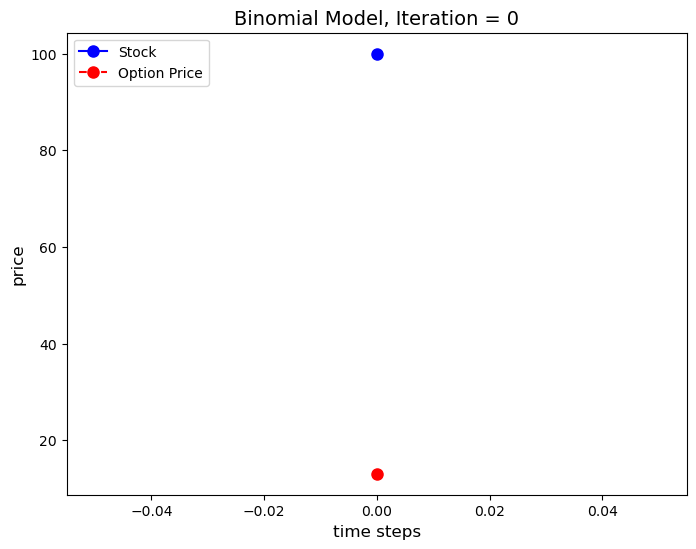

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import FancyArrowPatch
from matplotlib.animation import PillowWriter
from IPython.display import HTML

# parameters for option pricing
S0 = 100
K = 100
T = 1     # time to maturity (in years)
r = 0.1  # risk-free rate
sigma = 0.2  # volatility
n_steps = 12  # number of time steps in binomial tree

# binomial tree model for american option pricing
def binomial_tree_american(S0, K, T, r, sigma, n_steps):
    # time step size
    dt = T / n_steps
    # up and down factors
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    # risk-neutral probability
    p = (np.exp(r * dt) - d) / (u - d)

    # create stock and option trees
    stock_tree = np.zeros((n_steps + 1, n_steps + 1))
    option_tree = np.zeros((n_steps + 1, n_steps + 1))

    # calculate stock prices at each node
    for i in range(n_steps + 1):
        for j in range(i + 1):
            stock_tree[j, i] = S0 * (u ** (i - j)) * (d ** j)

    # calculate option payoff at maturity
    for j in range(n_steps + 1):
        option_tree[j, n_steps] = max(stock_tree[j, n_steps] - K, 0)

    # work backwards to price the option
    for i in range(n_steps - 1, -1, -1):
        for j in range(i + 1):
            exercise = max(stock_tree[j, i] - K, 0)
            hold = np.exp(-r * dt) * (p * option_tree[j, i + 1] + (1 - p) * option_tree[j + 1, i + 1])
            option_tree[j, i] = max(exercise, hold)

    return stock_tree, option_tree

# visualization
def create_option_pricing_gif():
    # generate binomial tree for stock and option prices
    stock_tree, option_tree = binomial_tree_american(S0, K, T, r, sigma, n_steps)

    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        ax.set_title(f"Binomial Model, Iteration = {frame}", fontsize=14)
        ax.set_xlabel("time steps", fontsize=12)
        ax.set_ylabel("price", fontsize=12)

        # plot stock prices at the current step
        for i in range(frame + 1):
            ax.plot([i] * (i + 1), stock_tree[:i + 1, i], 'bo-', markersize=8, label='Stock' if i == 0 else "")

        # plot option prices at the current step
        for i in range(frame + 1):
            ax.plot([i] * (i + 1), option_tree[:i + 1, i], 'ro--', markersize=8, label='Option Price' if i == 0 else "")

        # draw arrows to indicate backward induction for option pricing
        if frame > 0:
            for j in range(frame):
                for i in range(j + 1):
                    ax.add_patch(FancyArrowPatch((j, stock_tree[i, j]), (j + 1, stock_tree[i, j + 1]), color='gray', arrowstyle='->', mutation_scale=10))
                    ax.add_patch(FancyArrowPatch((j, stock_tree[i, j]), (j + 1, stock_tree[i + 1, j + 1]), color='gray', arrowstyle='->', mutation_scale=10))
        
        # highlight the final payoff at maturity
        if frame == n_steps:
            ax.fill_between(np.arange(n_steps + 1), option_tree[:, n_steps], color='green', alpha=0.45, label='Early Exercise Region')

        # add labels and legend
        ax.legend(loc='upper left')

    # create animation
    ani = FuncAnimation(fig, update, frames=range(n_steps + 1), repeat=False)
    
    return ani

# display the animation inline in jupyter
ani = create_option_pricing_gif();
HTML(ani.to_jshtml())
ani.save("option_pricing.gif", writer=PillowWriter(fps=2), dpi=300)

### Monte Carlo: European Option

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


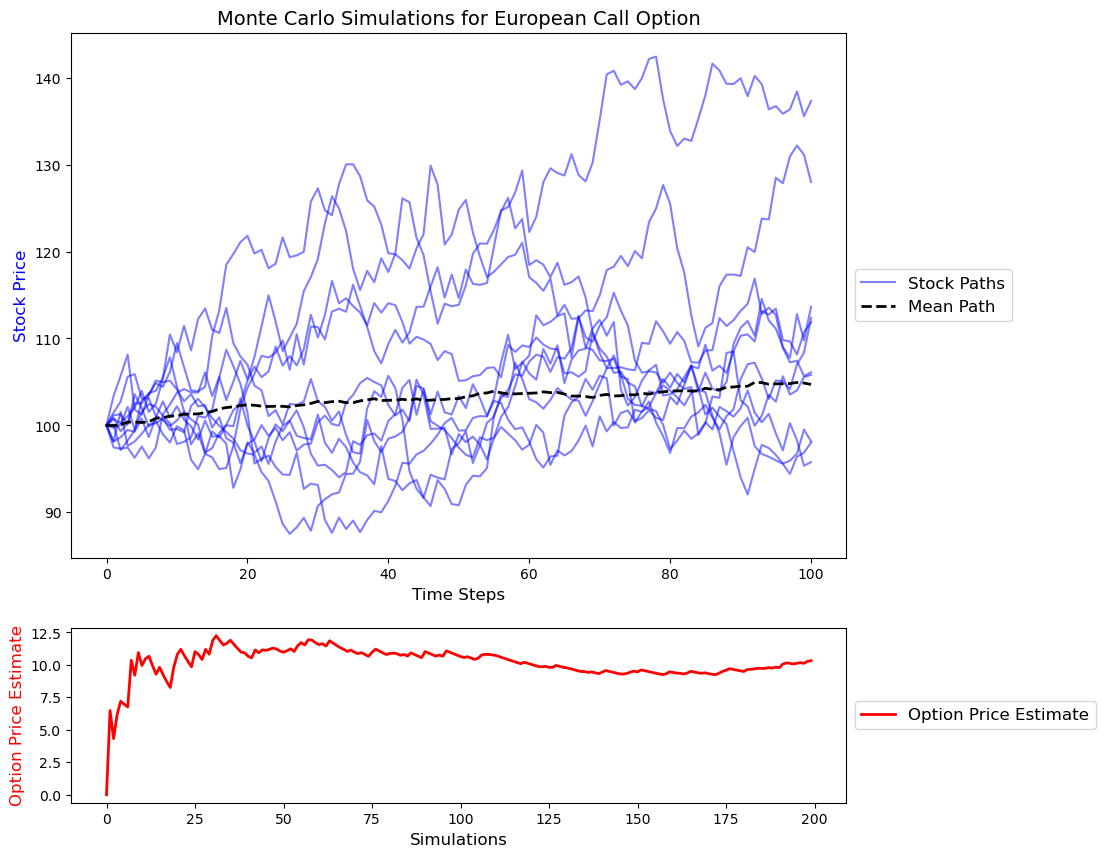

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# parameters for monte carlo pricing
S0 = 100  # initial stock price
K = 100   # strike price
T = 1     # time to maturity (in years)
r = 0.05  # risk-free rate
sigma = 0.2  # volatility
n_simulations = 200  # number of monte carlo simulations
n_steps = 100  # number of steps in each simulation

# monte carlo simulation for european option pricing
def monte_carlo_european(S0, K, T, r, sigma, n_simulations, n_steps):
    dt = T / n_steps
    stock_paths = np.zeros((n_simulations, n_steps + 1))
    stock_paths[:, 0] = S0
    
    for t in range(1, n_steps + 1):
        Z = np.random.standard_normal(n_simulations)
        stock_paths[:, t] = stock_paths[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    
    # calculate the option payoff at maturity
    payoffs = np.maximum(stock_paths[:, -1] - K, 0)
    
    # calculate discounted payoffs
    discounted_payoffs = np.exp(-r * T) * payoffs
    
    return stock_paths, discounted_payoffs

# create monte carlo simulation paths and option prices
stock_paths, discounted_payoffs = monte_carlo_european(S0, K, T, r, sigma, n_simulations, n_steps)

# initialize the option price array
option_price_evolution = np.zeros(n_simulations)

# visualization
def create_monte_carlo_gif():
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [3, 1]})
    
    ax1.set_xlabel("Time Steps", fontsize=12)
    ax1.set_ylabel("Stock Price", fontsize=12, color="blue")
    ax2.set_xlabel("Simulations", fontsize=12)
    ax2.set_ylabel("Option Price Estimate", fontsize=12, color="red")

    def update(frame):
        ax1.clear()
        ax2.clear()
        
        ax1.set_title("Monte Carlo Simulations for European Call Option", fontsize=14)
        ax1.set_xlabel("Time Steps", fontsize=12)
        ax1.set_ylabel("Stock Price", fontsize=12, color="blue")
        ax2.set_xlabel("Simulations", fontsize=12)
        ax2.set_ylabel("Option Price Estimate", fontsize=12, color="red")
        
        # plot a subset of the stock paths up to the current frame
        for i in range(min(10, n_simulations)):  # plotting 10 random paths
            ax1.plot(stock_paths[i, :frame + 1], color='blue', alpha=0.5, label='Stock Paths' if i == 0 else "")
        
        # plot the mean path
        mean_path = np.mean(stock_paths[:, :frame + 1], axis=0)
        ax1.plot(mean_path, color='black', linestyle='--', linewidth=2, label='Mean Path')

        # calculate the evolving option price estimate
        if frame > 0:
            current_payoffs = np.maximum(stock_paths[:frame, -1] - K, 0)
            current_option_price = np.exp(-r * T) * np.mean(current_payoffs[:frame])
            option_price_evolution[frame - 1] = current_option_price
            
            # plot the evolving option price on the second subplot
            ax2.plot(np.arange(frame), option_price_evolution[:frame], color="red", linestyle="-", linewidth=2, label='Option Price Estimate')

        # move the legend outside the plot
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

    # create animation
    ani = FuncAnimation(fig, update, frames=n_simulations + 1, repeat=False)
    
    # save animation as GIF
    ani.save("monte_carlo_pricing_with_option_convergence.gif", writer=PillowWriter(fps=10), dpi=300)

# create and save the GIF
create_monte_carlo_gif()
